# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.vq import vq, kmeans, whiten

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.head())


   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
azdias.shape

(891221, 85)

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
# count initial NaNs
nans_1 = len(azdias) - azdias.count()
# replace -1 by NaN and count
azdias.replace({-1:np.NaN}, inplace=True)  
nans_2 = len(azdias) - azdias.count()
# replace 0 by NaN and count
azdias.replace({0:np.NaN}, inplace=True)  
nans_3 = len(azdias) - azdias.count()

print("at the beginning: ", nans_1)
print("\nreplaced missings: ", nans_2-nans_1)
print("\nreplaced unknowns: ", nans_3-nans_2-nans_1)
            
print(nans_3)

at the beginning:  AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                     

In [1]:
print(azdias.head())

NameError: name 'azdias' is not defined

In [7]:
nans_3.keys()

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [8]:
nans_3.values

array([685843,      0,      0,   4854,      0,      0,      0,      0,
            0,      0,      0, 392318,   4854, 715996, 111196,  97632,
        94572,  77792,  77792,   4854,   4854, 108315, 108164,   4854,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0, 238778, 884333,
       889061, 111196,      0, 310267, 107602, 888041,  18348, 584612,
       147988,  73499,  99611, 867252,  93148,  73969,  93148,  93148,
       100098,  98979,  98979,  98979, 394373, 425862, 644869, 733495,
       476524, 133324,  93740,  93740,  93740,  93155, 158064, 133324,
        70570, 158064, 105862, 121985, 123953, 236309, 472904, 116515,
       116515, 116515,  97216,  97274,  97216])

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

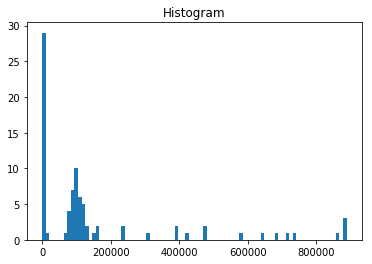

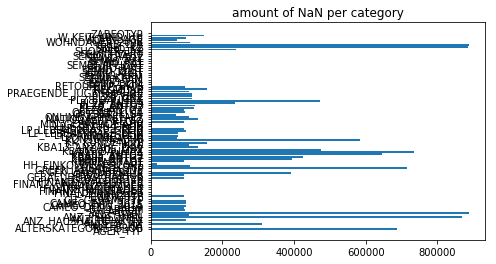

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(nans_3,azdias.shape[1])
plt.title("Histogram")
plt.show()
plt.barh(nans_3.keys(), nans_3.values)
plt.title("amount of NaN per category")
plt.show()

In [10]:
# Investigate patterns in the amount of missing data in each column.
nans = pd.Series(nans_3)
print(nans)


AGER_TYP                 685843
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE         715996
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
print(nans.values)

[685843      0      0   4854      0      0      0      0      0      0
      0 392318   4854 715996 111196  97632  94572  77792  77792   4854
   4854 108315 108164   4854      0      0      0      0      0      0
      0      0      0      0      0      0      0      0 238778 884333
 889061 111196      0 310267 107602 888041  18348 584612 147988  73499
  99611 867252  93148  73969  93148  93148 100098  98979  98979  98979
 394373 425862 644869 733495 476524 133324  93740  93740  93740  93155
 158064 133324  70570 158064 105862 121985 123953 236309 472904 116515
 116515 116515  97216  97274  97216]


In [12]:
nans_df = pd.DataFrame(nans.values.tolist(), index=nans.index)
print(nans_df)

                            0
AGER_TYP               685843
ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GEBURTSJAHR            392318
GFK_URLAUBERTYP          4854
GREEN_AVANTGARDE       715996
HEALTH_TYP             111196
LP_LEBENSPHASE_FEIN     97632
LP_LEBENSPHASE_GROB     94572
LP_FAMILIE_FEIN         77792
LP_FAMILIE_GROB         77792
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
NATIONALITAET_KZ       108315
PRAEGENDE_JUGENDJAHRE  108164
RETOURTYP_BK_S           4854
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
...                       ...
OST_WEST_KZ             93148
WOHNLAGE  

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
to_drop=[]
for lv in range(azdias.shape[1]):
    if nans.values[lv] >= 300000:
        to_drop.append(nans.index[lv])

print("drop:     ",to_drop)
#print(nans_df)




drop:      ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4']


#### Discussion 1.1.2: Assess Missing Data in Each Column

After the usual quick overview on the source dataframe (.describe(), .info()) I counted the initial NaN's (-> nans_1), replaced the "-1" (missing) and "0" (unknown) entrys and counted them as well (-> nans_2 and nans_3).

Histogram* and barchart with _nans_3_ show that the amount of NaN's is very high in some columns, partly > 90%. As these columns give therefore no input for further analysis all columns with a NaN rate >=50% are dropped out of the new dataframe (new_nans_df), reducing the columns from 85 to 74.
A NaN rate of >= 33.3% would reduce the columns to 70.

__decission__: outlier categories with >33.3% NaN will be dropped from the dataframe

*the Histogram shows on the x-axis the total amount of datasets (>890.000) with the bar-height representing the datasets with missing data in the same category. 



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
nan_in_row = azdias.shape[1] - azdias.count(axis=1)
print(nan_in_row)

0         50
1         10
2          9
3         17
4          8
5          9
6         12
7         12
8          8
9          7
10        10
11        54
12        15
13        14
14        54
15        17
16        17
17        54
18        15
19        10
20        22
21        12
22        12
23        17
24        54
25        19
26        28
27        11
28        12
29        10
          ..
891191     8
891192    12
891193     8
891194     9
891195     9
891196     9
891197     6
891198     9
891199    11
891200    10
891201     7
891202    11
891203    25
891204    10
891205    10
891206    11
891207     7
891208    15
891209    11
891210    11
891211    12
891212    12
891213     8
891214    10
891215    11
891216    14
891217    13
891218    17
891219    12
891220    12
Length: 891221, dtype: int64


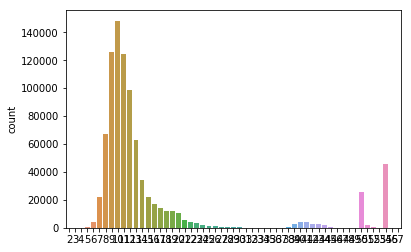

In [15]:
ax = sns.countplot(nan_in_row)

In [16]:
snir = pd.Series(nan_in_row)
snir.values

array([50, 10,  9, ..., 17, 12, 12], dtype=int64)

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# make Series of "nan_in_row" to access the value
snir = pd.Series(nan_in_row)

# split in 2 DF at 30 NaNs per row
azdias_low_nan = azdias[snir.values < 30]
azdias_high_nan = azdias[snir.values >= 30]
trash = azdias[snir.values >= 49]

print("low: ", azdias_low_nan.shape)
print("high: ",azdias_high_nan.shape)
print("trash: ",trash.shape)


low:  (797240, 85)
high:  (93981, 85)
trash:  (74024, 85)


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
nan_low_in_row = azdias_low_nan.shape[1] - azdias_low_nan.count(axis=1)
nan_high_in_row = azdias_high_nan.shape[1] - azdias_high_nan.count(axis=1)


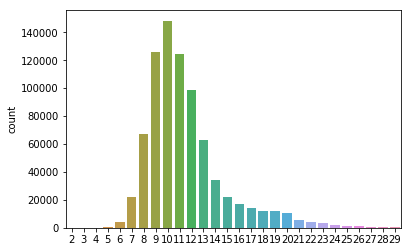

In [19]:
ax = sns.countplot(nan_low_in_row)

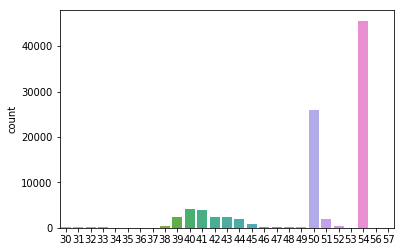

In [20]:
bx = sns.countplot(nan_high_in_row)

#### Discussion 1.1.3: Assess Missing Data in Each Row

analysing the rows show that all datasets miss some data (contain NaN's). Most of them show around 10 NaN's with a 'classical' Gaussian distribution.

another Gaussian distribution can be found around 40 NaN's (only few datasets) and peaks at 50 and 54 NaN's.
These peaks shall be omitted as it seems that this is no valid data

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
feat_info.type

0     categorical
1         ordinal
2     categorical
3     categorical
4         ordinal
5         ordinal
6         ordinal
7         ordinal
8         ordinal
9         ordinal
10    categorical
11        numeric
12    categorical
13    categorical
14        ordinal
15          mixed
16          mixed
17    categorical
18    categorical
19    categorical
20    categorical
21    categorical
22          mixed
23        ordinal
24        ordinal
25        ordinal
26        ordinal
27        ordinal
28        ordinal
29        ordinal
         ...     
55    categorical
56          mixed
57    categorical
58    categorical
59          mixed
60        ordinal
61        ordinal
62        ordinal
63        ordinal
64          mixed
65        ordinal
66        ordinal
67        ordinal
68        ordinal
69        ordinal
70        ordinal
71        ordinal
72        ordinal
73        ordinal
74        numeric
75        ordinal
76        ordinal
77        ordinal
78        ordinal
79        

In [21]:
# How many features are there of each data type?

sum_types = len(feat_info.groupby("type").groups)
print("sum of types ", sum_types)

types = feat_info.groupby("type").groups
keys = types.keys()
print(keys)
print("===")

for lv in types:
    print("type", lv, "has", len(types.get(lv)), "entries")

sum of types  5
dict_keys(['categorical', 'interval', 'mixed', 'numeric', 'ordinal'])
===
type categorical has 21 entries
type interval has 1 entries
type mixed has 7 entries
type numeric has 7 entries
type ordinal has 49 entries



#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
ind = types.get("categorical")
print(ind)
print(ind.values)
for lv in range(len(ind)):
    index = ind.values[lv]
    col_name = feat_info["attribute"][index:index+1] 
    typ = azdias.groupby(col_name.values[0]).groups
    print("attribute",col_name.values[0],"has",len(typ),"variants:")
    for lv1 in typ:
        print("    variant", lv1, "has", len(typ.get(lv1)), "entries")    
    
    

Int64Index([0, 2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 40, 41, 42, 47,
            52, 55, 57, 58],
           dtype='int64')
[ 0  2  3 10 12 13 17 18 19 20 21 38 39 40 41 42 47 52 55 57 58]
attribute AGER_TYP has 3 variants:
    variant 1.0 has 79802 entries
    variant 2.0 has 98472 entries
    variant 3.0 has 27104 entries
attribute ANREDE_KZ has 2 variants:
    variant 1.0 has 425916 entries
    variant 2.0 has 465305 entries
attribute CJT_GESAMTTYP has 6 variants:
    variant 1.0 has 98869 entries
    variant 2.0 has 148795 entries
    variant 3.0 has 156449 entries
    variant 4.0 has 210963 entries
    variant 5.0 has 117376 entries
    variant 6.0 has 153915 entries
attribute FINANZTYP has 6 variants:
    variant 1.0 has 199572 entries
    variant 2.0 has 110867 entries
    variant 3.0 has 53354 entries
    variant 4.0 has 130625 entries
    variant 5.0 has 106436 entries
    variant 6.0 has 290367 entries
attribute GFK_URLAUBERTYP has 12 variants:
    variant 1.0 has 536

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.
# replace "O" and "W" in OST_WEST_KZ
# no special treatment neccessary as this is the only column with such entries

azdias.replace({'O':0, 'W':1}, inplace=True)  

In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias.drop(['OST_WEST_KZ', 'CAMEO_DEU_2015'], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

- rows with too much "NaN's" (more then 30 out of 85) are dropped as the validity of these columns is questionable.
- entries of OST_WEST_KZ are replaced: 'O' by '0' (zero) and 'W' by '1' (one).
- entries of CAMEO_DEU_2015 are dropped as they differ only within a small range and therefore give no additional information.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
# check which "mixed" we have
ind = types.get("mixed")
print(ind)
print(ind.values)
for lv in range(len(ind)):
    index = ind.values[lv]
    col_name = feat_info["attribute"][index:index+1] 
    typ = azdias.groupby(col_name.values[0]).groups
    print("attribute",col_name.values[0],"has",len(typ),"variants:")
    for lv1 in typ:
        print("    variant", lv1, "has", len(typ.get(lv1)), "entries")

Int64Index([15, 16, 22, 56, 59, 64, 79], dtype='int64')
[15 16 22 56 59 64 79]
attribute LP_LEBENSPHASE_FEIN has 40 variants:
    variant 1.0 has 62667 entries
    variant 2.0 has 39434 entries
    variant 3.0 has 19985 entries
    variant 4.0 has 17595 entries
    variant 5.0 has 55542 entries
    variant 6.0 has 45614 entries
    variant 7.0 has 26508 entries
    variant 8.0 has 30475 entries
    variant 9.0 has 13066 entries
    variant 10.0 has 25789 entries
    variant 11.0 has 26710 entries
    variant 12.0 has 23300 entries
    variant 13.0 has 26085 entries
    variant 14.0 has 17529 entries
    variant 15.0 has 20062 entries
    variant 16.0 has 14466 entries
    variant 17.0 has 5888 entries
    variant 18.0 has 7168 entries
    variant 19.0 has 19484 entries
    variant 20.0 has 17132 entries
    variant 21.0 has 12766 entries
    variant 22.0 has 7224 entries
    variant 23.0 has 9191 entries
    variant 24.0 has 12091 entries
    variant 25.0 has 10370 entries
    variant 

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mainstream = (1,3,5,8,10,12,14)
avantgarde = (2,4,6,7,9,11,13,15)
movement = np.empty(azdias.shape[0], float)
print(mainstream)
print(avantgarde)

for lv in range(azdias.shape[0]):
    if azdias['PRAEGENDE_JUGENDJAHRE'][lv] in mainstream:
        movement[lv] = 0
    elif azdias['PRAEGENDE_JUGENDJAHRE'][lv] in avantgarde:
        movement[lv] = 1
    else:
        movement[lv] = np.NaN

print(movement)
azdias['movement'] = movement

(1, 3, 5, 8, 10, 12, 14)
(2, 4, 6, 7, 9, 11, 13, 15)
[ nan   0.   1. ...,   0.   0.   0.]


In [26]:
# decade
d_40s = (1,2)
d_50s = (3,4)
d_60s = (5,6,7)
d_70s = (8,9)
d_80s = (10,11,12,13)
d_90s = (14,15)

decade = np.empty(azdias.shape[0], float)

for lv in range(azdias.shape[0]):
    if azdias['PRAEGENDE_JUGENDJAHRE'][lv] in d_40s:
        decade[lv] = 0
    elif azdias['PRAEGENDE_JUGENDJAHRE'][lv] in d_50s:
        decade[lv] = 1
    elif azdias['PRAEGENDE_JUGENDJAHRE'][lv] in d_60s:
        decade[lv] = 2
    elif azdias['PRAEGENDE_JUGENDJAHRE'][lv] in d_70s:
        decade[lv] = 3
    elif azdias['PRAEGENDE_JUGENDJAHRE'][lv] in d_80s:
        decade[lv] = 4
    elif azdias['PRAEGENDE_JUGENDJAHRE'][lv] in d_90s:
        decade[lv] = 5
    else:
        decade[lv] = np.NaN

print(decade)
azdias['decade'] = decade

[ nan   5.   5. ...,   5.   5.   1.]


In [29]:
azdias.head

<bound method NDFrame.head of         AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0            NaN                   2.0        1.0            2.0   
1            NaN                   1.0        2.0            5.0   
2            NaN                   3.0        2.0            3.0   
3            2.0                   4.0        2.0            2.0   
4            NaN                   3.0        1.0            5.0   
5            3.0                   1.0        2.0            2.0   
6            NaN                   2.0        2.0            5.0   
7            NaN                   1.0        1.0            3.0   
8            NaN                   3.0        1.0            3.0   
9            NaN                   3.0        2.0            4.0   
10           NaN                   3.0        2.0            1.0   
11           NaN                   2.0        1.0            6.0   
12           NaN                   3.0        1.0            6.0   
13           NaN  

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

wealth = np.empty(azdias.shape[0], float)
stage = np.empty(azdias.shape[0], float)

for lv in range(azdias.shape[0]):
    if str(azdias['CAMEO_INTL_2015'][lv]) == "nan":
        wealth[lv] = np.NaN
        stage[lv] = np.NaN
    elif str(azdias['CAMEO_INTL_2015'][lv]) == "XX":
        wealth[lv] = np.NaN
        stage[lv] = np.NaN
    else:
        # calc wealth: divide entry by 10, conv to int (drops decimals)
        wealth[lv] = (int(int(azdias['CAMEO_INTL_2015'][lv])/10))
        
        # calc stage: subtract 10*wealth from entry
        stage[lv] = (int(azdias['CAMEO_INTL_2015'][lv])) - (wealth[lv]*10)
        #stage[lv] = (int(azdias['CAMEO_INTL_2015'][lv])) - (int(int(azdias['CAMEO_INTL_2015'][lv])/10)*10)

#print(wealth)
#print(stage)
azdias['stage'] = stage
azdias['wealth'] = wealth

#### Discussion 1.2.2: Engineer Mixed-Type Features

part "PRAEGENDE_JUGENDJAHRE":
- as there is no (obvious) math to split 'PRAEGENDE_JUGENDJAHRE' in "mainstream" and "avantgarde" I defined two lists according to the entries in "Data_Dictionary.md".
- same approach with the decades: 6 lists according to the 6 decades. There might be a more fancy way possible in python but it works well.
- 2 new columns (_movement_ and _decade_) were added to azdias at the end

part "CAMEO_INTL_2015":
- special handling for NaNs and XX: both lead to "NaN"
- the distinction between "wealth" and "stage" can be derived from the input:
- wealth is the ten's place: divide value by ten and make it an int
- stage is the one's place: subtract (10 * wealth) from value
- 2 new columns (_stage_ and _wealth_) were added to azdias at the end

both columns (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) are removed from the source

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# ignore rows with more than 30 (out of 85) NaN's (see above)
azdias_red = azdias[snir.values < 30]
print("removed ",azdias.shape[0]-azdias_red.shape[0]," entries (rows)")

removed  93981  entries (rows)


In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# reduce the dataset by the columns with > 300k NaNs (see above)
print("to be dropped: ",to_drop)
new_azdias = azdias_red.drop(labels=to_drop, axis=1)
print("new shape: ",new_azdias.shape)

to be dropped:  ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4']
new shape:  (797240, 74)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df, to_drop):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # some settings
    #to_drop=[]
    limit_nans_in_col = 300000
    limit_nans_in_row = 30
    movement = np.empty(df.shape[0], float)
    decade = np.empty(df.shape[0], float)    
    wealth = np.empty(df.shape[0], float)
    stage = np.empty(df.shape[0], float)
    
    # decade
    d_40s = (1,2)
    d_50s = (3,4)
    d_60s = (5,6,7)
    d_70s = (8,9)
    d_80s = (10,11,12,13)
    d_90s = (14,15)
    
    #movement
    mainstream = (1,3,5,8,10,12,14)
    avantgarde = (2,4,6,7,9,11,13,15)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print("replace '-1', '0' and X's by NaN's...")
    nans_begin = len(df) - df.count()
    df.replace({-1:np.NaN}, inplace=True)  
    df.replace({0:np.NaN}, inplace=True)  
    df.replace({'X':np.NaN}, inplace=True)  
    df.replace({'XX':np.NaN}, inplace=True)  
    nans_end = len(df) - df.count()

    print("make data numbers-only:")
    print("OST_WEST_KZ...")
    df.replace({'O':0, 'W':1}, inplace=True) 
    
    print("process PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015...")
    for lv in range(df.shape[0]):
        # define movement
        if df['PRAEGENDE_JUGENDJAHRE'][lv] in mainstream:
            movement[lv] = 0
        elif df['PRAEGENDE_JUGENDJAHRE'][lv] in avantgarde:
            movement[lv] = 1
        else:
            movement[lv] = np.NaN

        # defnie decade
        if df['PRAEGENDE_JUGENDJAHRE'][lv] in d_40s:
            decade[lv] = 0
        elif df['PRAEGENDE_JUGENDJAHRE'][lv] in d_50s:
            decade[lv] = 1
        elif df['PRAEGENDE_JUGENDJAHRE'][lv] in d_60s:
            decade[lv] = 2
        elif df['PRAEGENDE_JUGENDJAHRE'][lv] in d_70s:
            decade[lv] = 3
        elif df['PRAEGENDE_JUGENDJAHRE'][lv] in d_80s:
            decade[lv] = 4
        elif df['PRAEGENDE_JUGENDJAHRE'][lv] in d_90s:
            decade[lv] = 5
        else:
            decade[lv] = np.NaN

        # define stage and wealth
        if str(df['CAMEO_INTL_2015'][lv]) == "nan":
            wealth[lv] = np.NaN
            stage[lv] = np.NaN
        elif str(df['CAMEO_INTL_2015'][lv]) == "XX":
            wealth[lv] = np.NaN
            stage[lv] = np.NaN
        else:
            # calc wealth: divide entry by 10, conv to int (drops decimals)
            wealth[lv] = (int(int(df['CAMEO_INTL_2015'][lv])/10))

            # calc stage: subtract 10*wealth from entry
            stage[lv] = (int(df['CAMEO_INTL_2015'][lv])) - (wealth[lv]*10)

    df['movement'] = movement   
    df['decade'] = decade
    df['stage'] = stage
    df['wealth'] = wealth

    # remove selected columns and rows, ...
    print("to_drop:", to_drop)
    if (to_drop == []):
        print("define columns to be dropped...")
        for lv in range(df.shape[1]):
            if nans_end.values[lv] >= limit_nans_in_col:
                to_drop.append(nans_end.index[lv])       
        to_drop.append('OST_WEST_KZ')
        to_drop.append('CAMEO_DEU_2015')
        to_drop.append('PRAEGENDE_JUGENDJAHRE')
        to_drop.append('CAMEO_INTL_2015')
    
    # remove rows with more than <limit_nans_in_row> NaN's
    print("define rows to be dropped...")
    nan_in_row = df.shape[1] - df.count(axis=1)
    snir = pd.Series(nan_in_row)
    #print(snir)
    print("orig. shape", df.shape)
    df_red = df[snir.values < limit_nans_in_row]
    print("reduced shape", df_red.shape)
    print("removed ",df.shape[0]-df_red.shape[0]," entries (rows)")
    
    #df_red1 = df_red.drop(['OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    #print(df_red1.keys())
    #print(df_red1.shape)

    # reduce the dataset by the columns with more than <limit_nans_in_col> NaNs 
    print("to be dropped: ",to_drop)
    final_df = df_red.drop(labels=to_drop, axis=1)
    print("final shape: ",final_df.shape)
    #print(final_df.keys())

    # Return the cleaned dataframe.
    return final_df, to_drop
 

In [5]:
to_drop=[]
new_df, to_drop = clean_data(azdias, to_drop)
print("to_drop outside",to_drop)

replace '-1', '0' and X's by NaN's...
make data numbers-only:
OST_WEST_KZ...
process PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015...
to_drop: []
define columns to be dropped...
define rows to be dropped...
orig. shape (891221, 89)
reduced shape (796454, 89)
removed  94767  entries (rows)
to be dropped:  ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4', 'movement', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
final shape:  (796454, 69)
to_drop outside ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4', 'movement', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']


In [29]:
print(new_df.shape)

(796454, 69)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [6]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp = p.Imputer(missing_values=np.NaN, strategy='mean',copy=True)
scaled_azdias = pd.DataFrame(imp.fit_transform(new_df))

In [7]:
# Apply feature scaling to the general population demographics data.
azdias_ss = p.StandardScaler(with_mean=False, with_std=True).fit_transform(scaled_azdias)

In [71]:
print(azdias_ss)

[[ 0.92524275  4.00366522  3.26189551 ...,  3.49234482  0.67574735
   3.42562757]
 [ 2.77572826  4.00366522  1.9571373  ...,  3.49234482  2.70298941
   1.37025103]
 [ 3.70097101  4.00366522  1.3047582  ...,  2.09540689  1.35149471
   0.68512551]
 ..., 
 [ 1.85048551  4.00366522  2.6095164  ...,  3.49234482  2.70298941
   1.37025103]
 [ 0.92524275  2.00183261  1.9571373  ...,  3.49234482  0.67574735
   3.42562757]
 [ 3.70097101  2.00183261  0.6523791  ...,  0.69846896  2.02724206
   2.74050206]]


### Discussion 2.1: Apply Feature Scaling

after cleaning the data (which reduces the shape from (891221, 89) to (796454, 69)) all NaN's in the remaining data are replaced by the mean value of the column and scaled by sklearn StandardScaler.

I use Imputer because almost every row contains at least one "NaN" and threrefore almost every data would be skipped. Same effect on temporarily removing these datasets. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [9]:
# reuse the do_pca function from prior class
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [10]:
pca, X_pca = do_pca(None, azdias_ss)

In [11]:
pca.explained_variance_ratio_

array([  1.76975876e-01,   1.28861672e-01,   8.97211475e-02,
         6.38275992e-02,   4.06662592e-02,   3.35382990e-02,
         2.61233166e-02,   2.28696467e-02,   2.24888582e-02,
         2.16273259e-02,   1.88238450e-02,   1.67612476e-02,
         1.51872229e-02,   1.46649990e-02,   1.42155457e-02,
         1.41275234e-02,   1.33285619e-02,   1.31562553e-02,
         1.29365008e-02,   1.25299065e-02,   1.19618827e-02,
         1.15591132e-02,   1.07556148e-02,   1.04430147e-02,
         9.98340112e-03,   9.52270385e-03,   9.17189219e-03,
         8.74192669e-03,   8.39573632e-03,   7.53967524e-03,
         7.21665507e-03,   7.19639222e-03,   6.88174190e-03,
         6.46654554e-03,   6.28020066e-03,   5.75964069e-03,
         5.61899123e-03,   5.39555132e-03,   4.82615572e-03,
         4.69614990e-03,   4.57763508e-03,   4.08922977e-03,
         4.03746667e-03,   3.92095535e-03,   3.88487616e-03,
         3.76258893e-03,   3.55859510e-03,   3.50310412e-03,
         3.33911989e-03,

In [14]:
X_pca.shape

(796454, 69)

In [15]:
# reuse the scree_plot function from prior class

def scree_plot(pca, thres=1.0):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
           thres - threshold requested (0-1) 
            
    OUTPUT: number of components to meet threshold requirement
            
    '''
    ret_value = 0
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    for lv in range(len(ind)):
        if ((cumvals[lv] >= thres) and (ret_value == 0)):
            ret_value = lv

    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    return ret_value

27


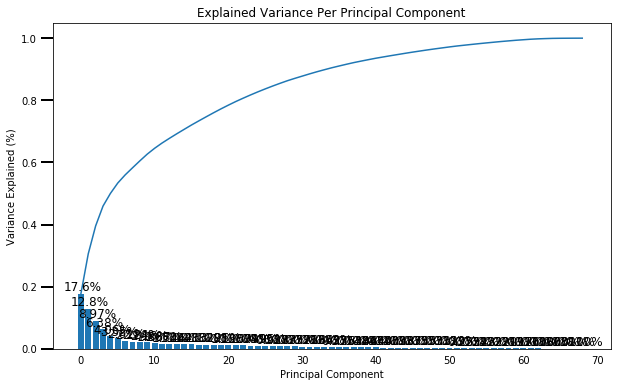

In [16]:
components = scree_plot(pca, 0.85)
print(components)

In [ ]:
# Investigate the variance accounted for by each principal component.



In [17]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(components, azdias_ss)



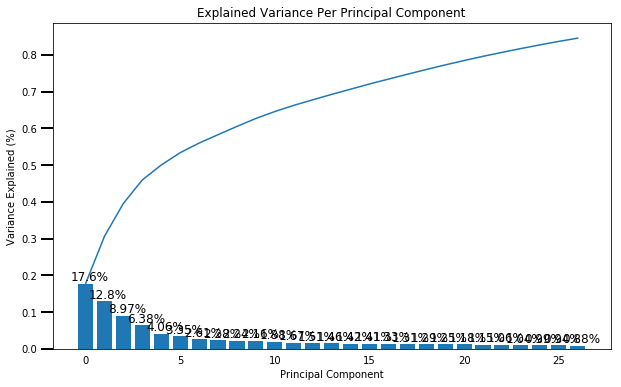

In [18]:
components1 = scree_plot(pca)


In [19]:
def pca_results(full_dataset, pca, show_dim=-1):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results (the first _show_dim_ or all if not set)
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    #components.plot(ax = ax, kind = 'bar');
    comp = components[0:show_dim]
    comp.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(dimensions, rotation=0)
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
        if ((i >= show_dim-1) and (show_dim > -1)):
            break

    # Return a concatenated DataFrame
    #return pd.concat([variance_ratios, components], axis = 1)
    return variance_ratios, components

(796454, 69)
(27, 69)
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
       'WOHNLAGE', 'CAMEO_DEUG_2015', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO

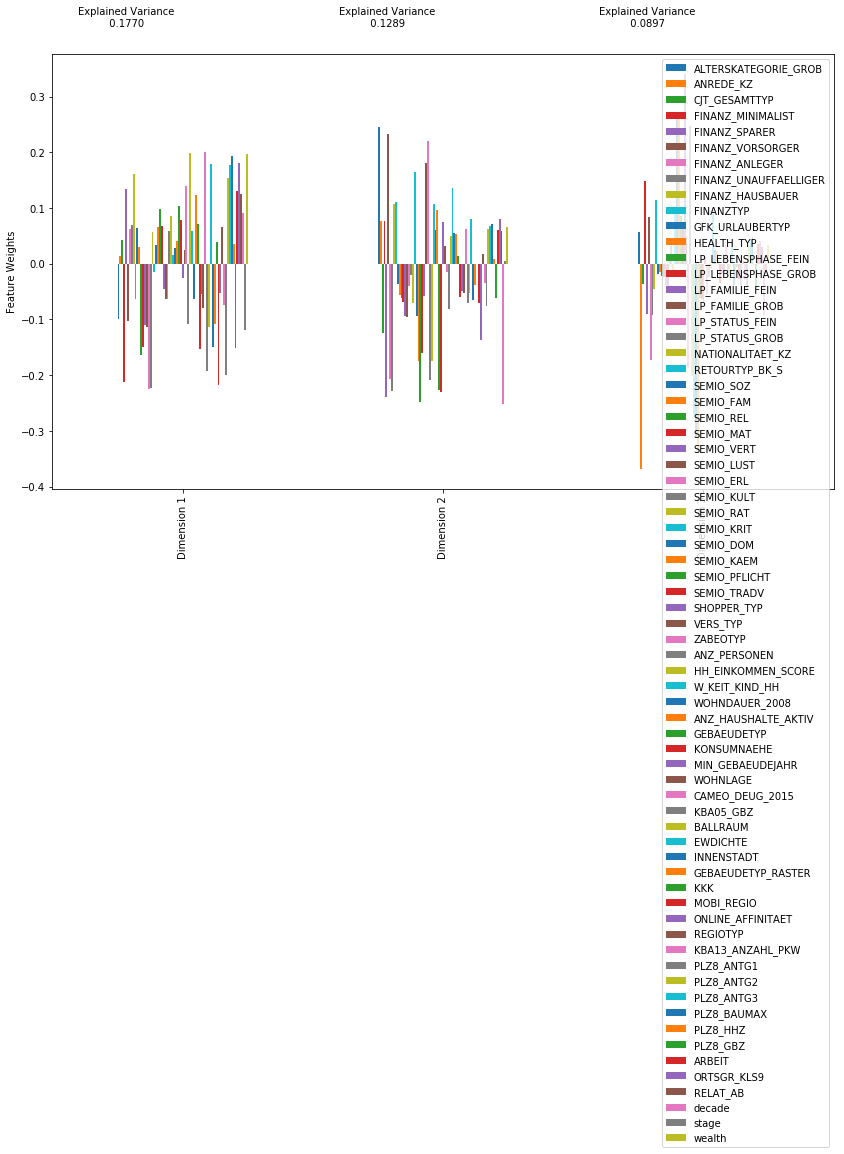

In [20]:
var_ratios, result = pca_results(new_df, pca, 3)
print(new_df.shape)
print(result.shape)
print(new_df.keys())
print(result.keys())
print(var_ratios)
#print("result ")
#print(result)

In [37]:
result

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,stage,wealth
Dimension 1,-0.0988,0.0138,0.0432,-0.2127,0.1345,-0.1022,0.0623,0.0692,0.1606,-0.0641,...,0.1766,0.1932,0.0350,-0.1509,0.1298,0.1804,0.1243,0.0902,-0.1199,0.1970
Dimension 2,0.2449,0.0769,-0.1250,0.0771,-0.2385,0.2331,-0.2078,-0.2282,0.1071,0.1099,...,0.0673,0.0709,0.0076,-0.0624,0.0609,0.0797,0.0580,-0.2526,0.0053,0.0665
Dimension 3,0.0570,-0.3686,-0.0358,0.1482,-0.0912,0.0845,-0.1732,-0.0913,-0.0460,0.1151,...,0.0421,0.0480,-0.0019,-0.0414,0.0356,0.0411,0.0304,-0.0929,-0.0160,0.0339
Dimension 4,0.0143,0.0049,0.0548,0.0215,-0.0131,0.0160,-0.0450,-0.0270,-0.0131,0.0403,...,0.1210,0.1280,-0.0050,-0.1193,0.1097,0.1728,0.1113,0.0023,-0.0305,0.0511
Dimension 5,-0.0679,0.0178,0.0396,0.0753,-0.0175,-0.0191,-0.1548,0.0861,-0.1105,-0.0165,...,-0.0259,0.0215,0.2108,0.1268,0.0327,0.2433,0.0565,0.0199,0.1219,-0.2039
Dimension 6,0.0441,-0.0201,-0.0222,-0.1277,0.0139,0.0648,-0.0047,0.0147,0.1616,-0.0997,...,-0.1073,-0.0769,0.4918,0.3813,-0.1678,-0.0732,-0.1390,-0.0331,-0.0364,0.0553
Dimension 7,0.0300,0.0444,-0.0576,-0.0919,-0.0048,-0.0112,-0.0294,0.0055,0.1574,-0.0514,...,0.0600,0.1267,-0.2139,-0.2130,-0.2125,-0.1552,-0.1847,-0.0331,0.0369,-0.0471
Dimension 8,-0.1218,0.0997,-0.0989,0.0941,-0.1852,0.1695,-0.1244,-0.2146,0.0743,0.1348,...,-0.0273,-0.0554,0.0371,0.0588,0.1019,-0.0134,0.0783,-0.2128,-0.0103,0.0776
Dimension 9,0.0289,0.0164,-0.0385,-0.1889,0.0605,0.0215,0.0415,0.1285,0.2781,-0.3035,...,-0.1286,-0.1720,-0.1274,0.0132,0.1394,0.1186,0.1248,-0.0406,0.2709,-0.1531
Dimension 10,0.1304,0.0382,0.0281,0.0408,0.0459,-0.0959,0.0465,0.1634,-0.1353,-0.1435,...,0.1330,0.1087,0.1515,0.0309,0.0407,0.0098,0.0528,0.0491,-0.1482,0.0918


### Discussion 2.2: Perform Dimensionality Reduction

after performing PCA with no changes to the default parameters as suggested I reused and enhanced the "scree_plot" function of the previous class to show a plot of the values.
I enhanced the function by a threshold value. The function now gives back the components (for further PCA analysis) to meet at least the threshold of accuracy.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(df, row):
    res = df.sort_values(by=[row], axis=1, na_position='last', ascending=False)
    print(res)
    fig, ax = plt.subplots(figsize = (14,8))
    res.plot(ax = ax, kind = 'bar');    


In [53]:
result[:3]

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG3,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,stage,wealth
Dimension 1,0.1770,-0.0988,0.0138,0.0432,-0.2127,0.1345,-0.1022,0.0623,0.0692,0.1606,...,0.1766,0.1932,0.0350,-0.1509,0.1298,0.1804,0.1243,0.0902,-0.1199,0.1970
Dimension 2,0.1289,0.2449,0.0769,-0.1250,0.0771,-0.2385,0.2331,-0.2078,-0.2282,0.1071,...,0.0673,0.0709,0.0076,-0.0624,0.0609,0.0797,0.0580,-0.2526,0.0053,0.0665
Dimension 3,0.0897,0.0570,-0.3686,-0.0358,0.1482,-0.0912,0.0845,-0.1732,-0.0913,-0.0460,...,0.0421,0.0480,-0.0019,-0.0414,0.0356,0.0411,0.0304,-0.0929,-0.0160,0.0339


             CAMEO_DEUG_2015  HH_EINKOMMEN_SCORE  wealth  PLZ8_BAUMAX  \
Dimension 1           0.2007              0.1985   0.197       0.1932   

             ORTSGR_KLS9  EWDICHTE  PLZ8_ANTG3  FINANZ_HAUSBAUER  PLZ8_ANTG2  \
Dimension 1       0.1804     0.178      0.1766            0.1606      0.1544   

             ZABEOTYP       ...        LP_LEBENSPHASE_GROB  PLZ8_GBZ  \
Dimension 1    0.1394       ...                    -0.1491   -0.1509   

             KONSUMNAEHE  LP_LEBENSPHASE_FEIN  KBA05_GBZ  PLZ8_ANTG1  \
Dimension 1       -0.154              -0.1635    -0.1925     -0.2004   

             FINANZ_MINIMALIST  MOBI_REGIO  LP_STATUS_GROB  LP_STATUS_FEIN  
Dimension 1            -0.2127     -0.2179         -0.2228         -0.2246  

[1 rows x 69 columns]


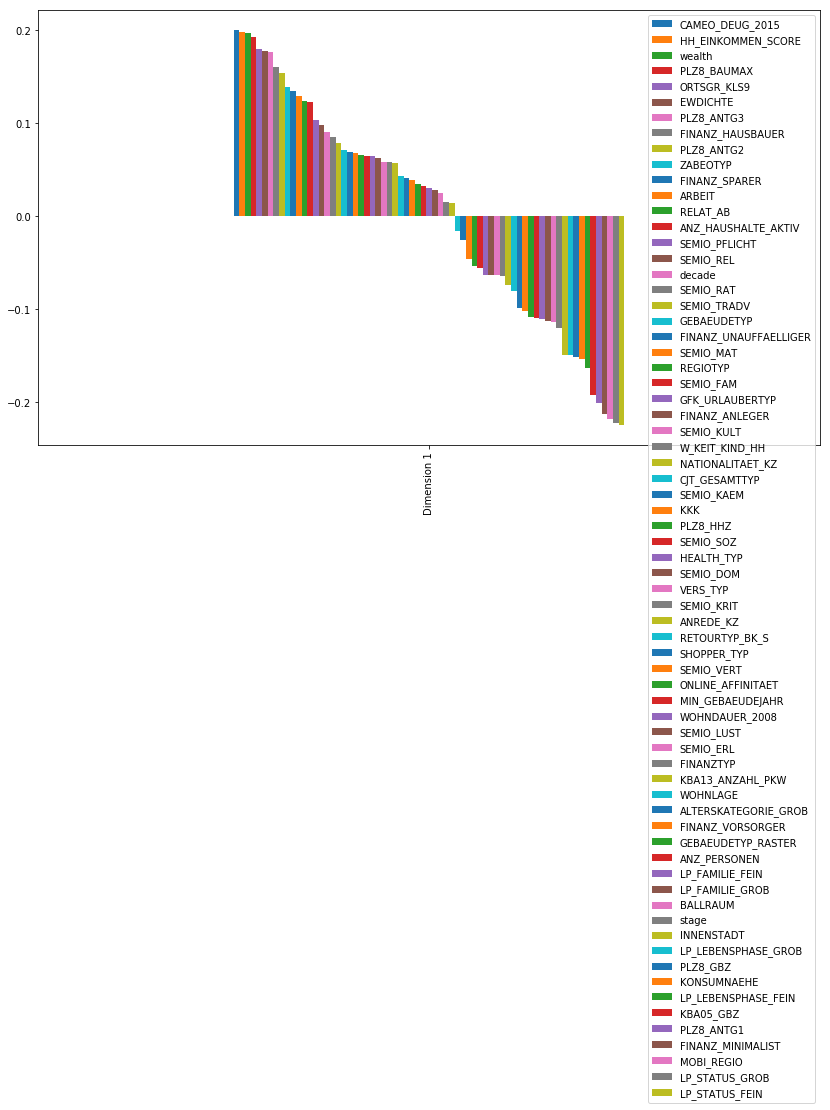

In [39]:
# Analyse 1st row
map_weights(result[0:1], 'Dimension 1')

             ALTERSKATEGORIE_GROB  FINANZ_VORSORGER  SEMIO_ERL  SEMIO_LUST  \
Dimension 2                0.2449            0.2331     0.2209      0.1806   

             RETOURTYP_BK_S  W_KEIT_KIND_HH  FINANZTYP  SEMIO_KRIT  \
Dimension 2          0.1637          0.1363     0.1099      0.1075   

             FINANZ_HAUSBAUER  SEMIO_KAEM   ...    SEMIO_FAM  SEMIO_RAT  \
Dimension 2            0.1071      0.0972   ...      -0.1745    -0.1747   

             FINANZ_ANLEGER  SEMIO_KULT  SEMIO_PFLICHT  FINANZ_UNAUFFAELLIGER  \
Dimension 2         -0.2078     -0.2086        -0.2275                -0.2282   

             SEMIO_TRADV  FINANZ_SPARER  SEMIO_REL  decade  
Dimension 2      -0.2296        -0.2385    -0.2491 -0.2526  

[1 rows x 69 columns]


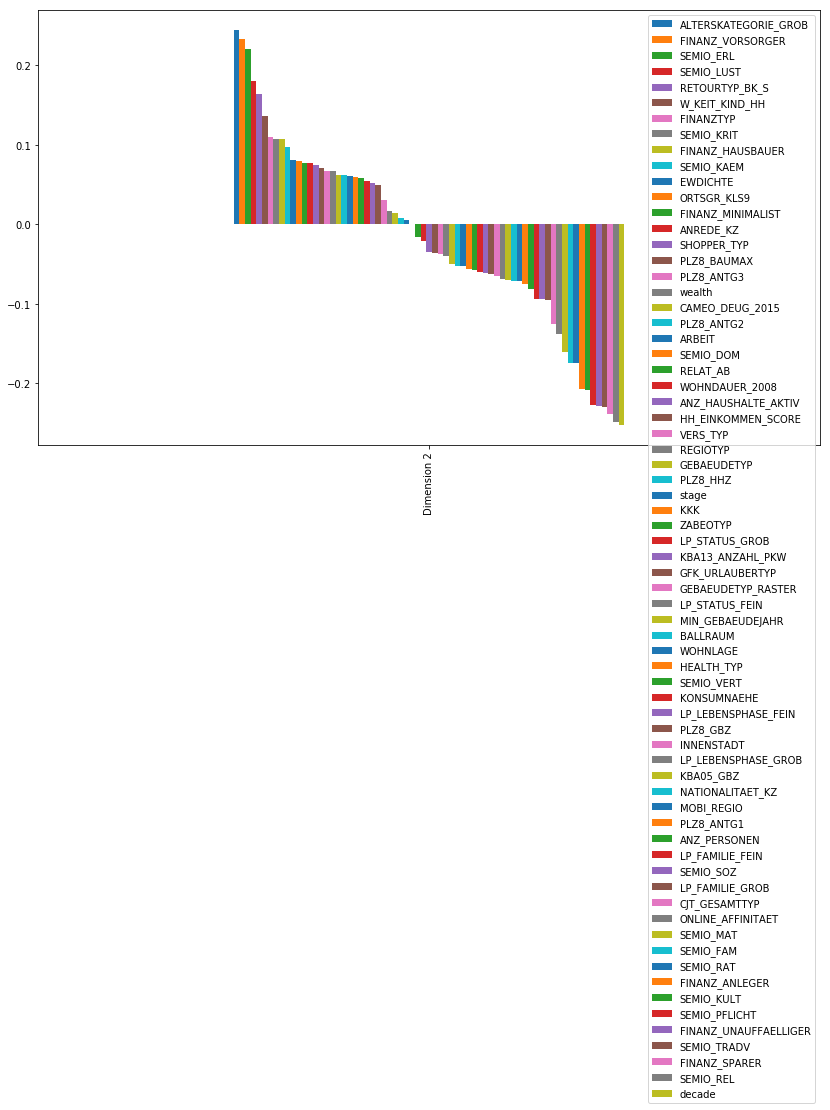

In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(result[1:2], 'Dimension 2')

             SEMIO_VERT  SEMIO_SOZ  SEMIO_FAM  SEMIO_KULT  FINANZ_MINIMALIST  \
Dimension 3      0.3403      0.263     0.2588      0.2468             0.1475   

             FINANZTYP  RETOURTYP_BK_S  W_KEIT_KIND_HH  Explained Variance  \
Dimension 3     0.1145          0.1005          0.0955              0.0885   

             SEMIO_REL    ...      FINANZ_UNAUFFAELLIGER  FINANZ_SPARER  \
Dimension 3     0.0864    ...                    -0.0902        -0.0905   

             decade  FINANZ_ANLEGER  SEMIO_ERL  SEMIO_RAT  SEMIO_KRIT  \
Dimension 3 -0.0921         -0.1741    -0.1875    -0.2008     -0.2728   

             SEMIO_DOM  SEMIO_KAEM  ANREDE_KZ  
Dimension 3    -0.3113     -0.3362    -0.3679  

[1 rows x 71 columns]


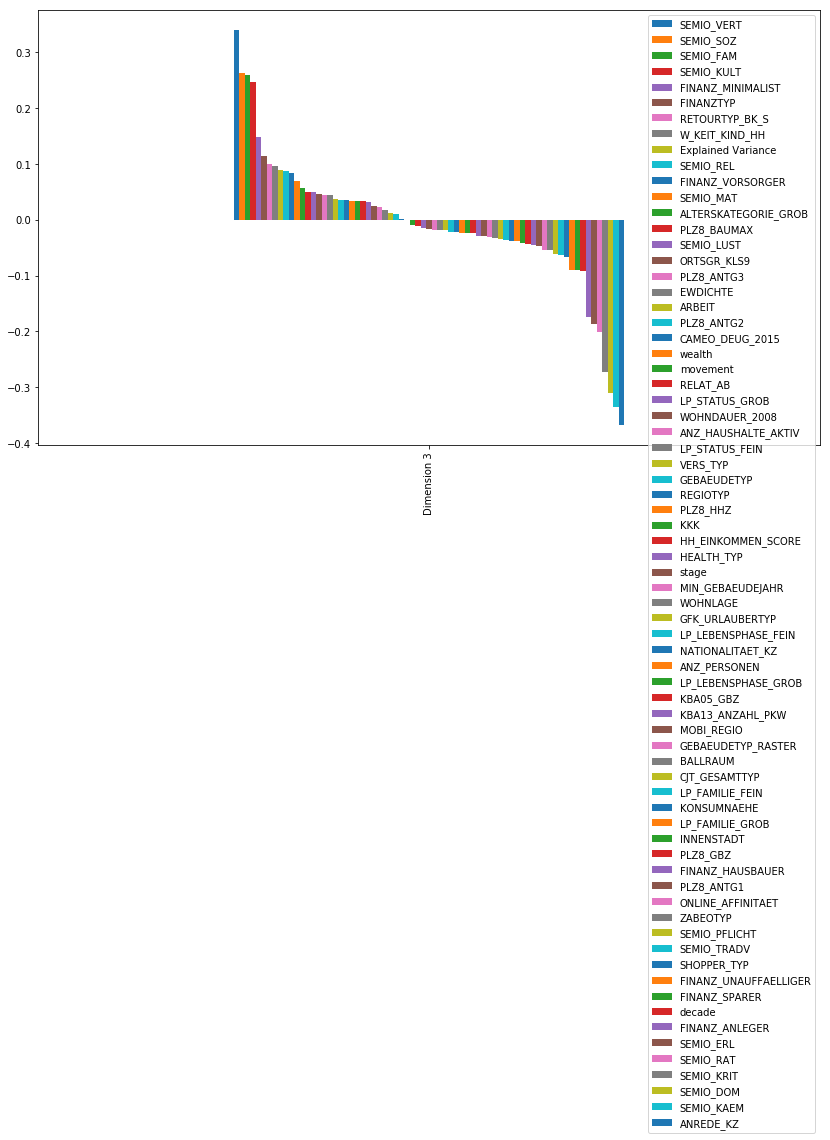

In [20]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(result[2:3], 'Dimension 3')

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [69]:
result.shape

(27, 70)

In [21]:
cluster_scores = []
n_cluster_list = []
n_clusters_max = 27
for n_clusters in range(1,n_clusters_max):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit_transform(result)
    # compute the average within-cluster distances.
    dist_score = kmeans.mean()
    cluster_scores.append(dist_score)
    n_cluster_list.append(n_clusters)
    
    print(cluster_scores)
    print(n_cluster_list)

[0.98130572900046564]
[1]
[0.98130572900046564, 1.0005576646732359]
[1, 2]
[0.98130572900046564, 1.0005576646732359, 1.0639571666172154]
[1, 2, 3]
[0.98130572900046564, 1.0005576646732359, 1.0639571666172154, 1.0742779537387153]
[1, 2, 3, 4]
[0.98130572900046564, 1.0005576646732359, 1.0639571666172154, 1.0742779537387153, 1.0932711530070216]
[1, 2, 3, 4, 5]
[0.98130572900046564, 1.0005576646732359, 1.0639571666172154, 1.0742779537387153, 1.0932711530070216, 1.1169982327795438]
[1, 2, 3, 4, 5, 6]
[0.98130572900046564, 1.0005576646732359, 1.0639571666172154, 1.0742779537387153, 1.0932711530070216, 1.1169982327795438, 1.1676553218798331]
[1, 2, 3, 4, 5, 6, 7]
[0.98130572900046564, 1.0005576646732359, 1.0639571666172154, 1.0742779537387153, 1.0932711530070216, 1.1169982327795438, 1.1676553218798331, 1.2023975257428947]
[1, 2, 3, 4, 5, 6, 7, 8]
[0.98130572900046564, 1.0005576646732359, 1.0639571666172154, 1.0742779537387153, 1.0932711530070216, 1.1169982327795438, 1.1676553218798331, 1.2023

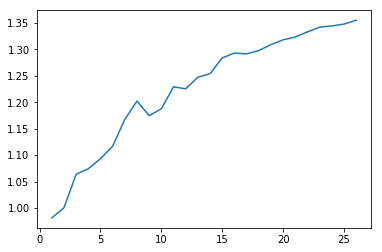

In [22]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(n_cluster_list,cluster_scores)

In [23]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=10)
model = kmeans.fit(result)
predict = model.predict(result)

In [24]:
predict

array([1, 1, 8, 3, 7, 4, 3, 5, 6, 3, 4, 1, 1, 4, 5, 2, 0, 9, 4, 1, 1, 1, 5,
       6, 4, 4, 5], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [50]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [51]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_df, trash = clean_data(customers, to_drop)


replace '-1', '0' and X's by NaN's...
make data numbers-only:
OST_WEST_KZ...
process PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015...
to_drop: ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4', 'movement', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
define rows to be dropped...
orig. shape (191652, 89)
reduced shape (141551, 89)
removed  50101  entries (rows)
to be dropped:  ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4', 'movement', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
final shape:  (141551, 69)


In [55]:
imp = p.Imputer(missing_values=np.NaN, strategy='mean',copy=True)
print(imp)
temp = imp.fit_transform(customer_df)   # fit should be ok here for the imputer
print(temp)
print(temp.shape)
customer_ss = p.StandardScaler(with_mean=False, with_std=True).fit_transform(temp)
print(customer_ss)
print(customer_ss.shape)

Imputer(axis=0, copy=True, missing_values=nan, strategy='mean', verbose=0)
[[ 4.  1.  5. ...,  1.  3.  1.]
 [ 4.  2.  2. ...,  1.  4.  3.]
 [ 4.  1.  2. ...,  0.  4.  2.]
 ..., 
 [ 4.  1.  2. ...,  1.  4.  2.]
 [ 3.  2.  4. ...,  3.  4.  2.]
 [ 2.  1.  2. ...,  1.  3.  3.]]
(141551, 69)
[[ 5.24636569  2.1255777   3.34439972 ...,  0.74587792  2.24259578
   0.71317223]
 [ 5.24636569  4.25115541  1.33775989 ...,  0.74587792  2.99012771
   2.1395167 ]
 [ 5.24636569  2.1255777   1.33775989 ...,  0.          2.99012771
   1.42634447]
 ..., 
 [ 5.24636569  2.1255777   1.33775989 ...,  0.74587792  2.99012771
   1.42634447]
 [ 3.93477426  4.25115541  2.67551978 ...,  2.23763376  2.99012771
   1.42634447]
 [ 2.62318284  2.1255777   1.33775989 ...,  0.74587792  2.24259578
   2.1395167 ]]
(141551, 69)


In [53]:
customers_pca = pca.transform(customer_ss)
print(customers_pca)
print(customers_pca.shape)

[[ -42.00703976  -32.67019709   -8.76545239 ...,   47.30689983
   -44.66356411 -143.96904536]
 [ -36.51514592  -28.34017166  -13.64617281 ...,   46.01095138
   -44.09145266 -143.8995257 ]
 [ -41.1372852   -33.42221624   -9.7404855  ...,   44.49772493
   -43.93470281 -145.33477987]
 ..., 
 [ -41.31696735  -31.02486443  -10.62436269 ...,   45.061782    -44.49598949
  -143.09413271]
 [ -37.07398467  -31.71253739  -15.45848907 ...,   44.4336468   -44.45913604
  -145.10510584]
 [ -40.78990233  -37.07803394   -9.79273836 ...,   45.57903988
   -44.83121245 -144.84481918]]
(141551, 27)


In [56]:
pred_customers = model.predict(customer_ss)

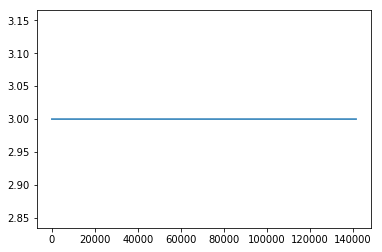

In [66]:
plt.plot(pred_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.